In [1]:
import os, json, numpy as np, pandas as pd, shap, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


/home/campus.stonybrook.edu/psurana/anaconda3/envs/dnabert_aug_2025_jupyter/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ──────────────────────────── Helpers ────────────────────────────
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def load_job_from_json(path, index=0):
    with open(path, "r") as f:
        obj = json.load(f)
    if isinstance(obj, list):
        job = obj[index]
    elif isinstance(obj, dict):
        job = obj
    else:
        raise ValueError("jobs.json must be dict or list")
    return job


In [3]:
def load_sequences(input_csv=None, seqs_txt=None, sequence_col="sequence", top_n=None):
    """
    If top_n is None → returns ALL sequences.
    Otherwise returns top-N by |prob_1 - prob_0|.
    """
    if seqs_txt and os.path.exists(seqs_txt):
        with open(seqs_txt) as f:
            return [ln.strip() for ln in f if ln.strip()]

    if input_csv and os.path.exists(input_csv):
        df = pd.read_csv(input_csv)
        if sequence_col not in df.columns:
            raise ValueError(f"Column {sequence_col} not in {input_csv}")
        # find prob columns
        p0 = p1 = None
        for c in df.columns:
            lc = c.lower().strip()
            if lc in ("prob_0","p0","prob0"): p0 = c
            if lc in ("prob_1","p1","prob1"): p1 = c
        if p0 is not None and p1 is not None and top_n is not None:
            df["_confidence"] = (df[p1] - df[p0]).abs()
            df = df.sort_values("_confidence", ascending=False).head(top_n)
        return df[sequence_col].astype(str).tolist()

    raise ValueError("Provide either input_csv or seqs_txt")


In [5]:
def build_predict_fn_idsafe(tokenizer, model, device, target_class=1):
    mask_id = getattr(tokenizer, "mask_token_id", None)
    pad_id  = getattr(tokenizer, "pad_token_id", None)
    unk_id  = getattr(tokenizer, "unk_token_id", 0)
    if mask_id is None:
        mask_id = pad_id if pad_id is not None else unk_id

    def predict_prob(token_arrays):
        arr = np.array(token_arrays, dtype=object)
        if arr.ndim == 1:
            arr = arr.reshape(1, -1)

        encoded_examples = []
        for row in arr:
            tok_ids = []
            for t in list(row):
                if t is None or t == "":
                    tok_ids.append(unk_id)
                elif isinstance(t, str):
                    tid = tokenizer.convert_tokens_to_ids(t)
                    tok_ids.append(unk_id if tid is None else tid)
                else:
                    tok_ids.append(int(t))  # already an id
            enc = tokenizer.prepare_for_model(tok_ids, add_special_tokens=True, truncation=True)
            encoded_examples.append(enc)

        batch = tokenizer.pad(encoded_examples, return_tensors="pt").to(device)
        with torch.no_grad():
            probs = torch.softmax(model(**batch).logits, dim=-1)[:, target_class]
        return probs.detach().cpu().numpy()

    mask_token = tokenizer.mask_token or tokenizer.pad_token or "[PAD]"
    return predict_prob, mask_token


In [6]:
def explain_sequence(seq, tokenizer, predict_fn, mask_token, max_len=512, nsamples=800):
    raw_tokens = tokenizer.tokenize(seq)[:max_len]
    if not raw_tokens:
        print("[WARN] Empty tokenization; skipping.")
        return None, None
    tokens = []
    for t in raw_tokens:
        if t is None or t == "":
            tokens.append(mask_token)
        elif isinstance(t, bytes):
            tokens.append(t.decode(errors="ignore"))
        else:
            tokens.append(str(t))

    background = np.array([[mask_token]*len(tokens)], dtype=object)
    explainer = shap.KernelExplainer(predict_fn, background, link="logit")
    shap_vals = explainer.shap_values(np.array(tokens, dtype=object), nsamples=nsamples)
    if isinstance(shap_vals, list):
        shap_vals = np.array(shap_vals[0])

    ev = explainer.expected_value
    if isinstance(ev, (list, np.ndarray)):
        ev = np.array(ev).reshape(-1)[0]

    ex = shap.Explanation(values=shap_vals, base_values=ev, data=tokens)
    df_tokens = pd.DataFrame({"token": tokens, "shap_value": shap_vals})
    return ex, df_tokens

In [13]:
jobs_path = "/data/private/psurana/TSProm/src/files/jobs1.json"
job = load_job_from_json(jobs_path, index=1)
job


{'base_model_nm': 'TSp_vs_genNullseqs',
 'subset': 'tspmuscle_genNullseqs',
 'lr_dir': 'lr3e-5_ep10',
 'model_path': '/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/july_2025_mmseq/TSp_vs_genNullseqs/3k/tspmuscle_genNullseqs/lr3e-5_ep10/checkpoint-300',
 'data_dir': '/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/data/jul_2025/split/TSp_vs_genNullseqs/3k/tspmuscle_genNullseqs',
 'res_pdir': '/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/july_2025_mmseq/RESULT/lr3e-5_ep10/TSp_vs_genNullseqs_3k_tspmuscle_genNullseqs'}

In [14]:
checkpoint = job["model_path"]
output_dir = os.path.join(job["res_pdir"], "shap")
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer_name = "jaandoui/DNABERT2-AttentionExtracted"

tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, trust_remote_code=True).to(device).eval()

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).


In [15]:
df_res=pd.read_csv(job["res_pdir"] + '/4sig_motifs_prePWM.csv')
print(df_res.shape)
df_res.head(2)

(52, 24)


,split_x,Sequence,Label,true_label,pred_label,prob_0,prob_1,Header,split_y,layer,...,token_length,mask,n_total,pos_hits,neg_hits,pval,adj_pval,hit_type,merged_token,window_seq
0,train,CTGGCGGAAGGGGCGGGGGCGAAGCCGTGCGCGCTGCCGCCTCACC...,1,1,1,0.016831,0.983169,chr17_4949119_4952119_4951119_+_muscle_2kTSS1k_1,train,4,...,7,1,92,77,15,3.199159e-13,1.005816e-09,both,GCGGCGG,ACGGCCGTGCGGCGGCCGCGGTGA
1,train,TTTCTTCGTGATTCCTGTTTTAACCAGTTTTCTCAATTAACCAAGC...,1,1,1,0.024027,0.975973,chr13_113207613_113210613_113209613_+_muscle_2...,train,5,...,6,1,145,109,36,9.775290e-13,1.536676e-09,both,GCGGCGG,GGCCCCCACGGCGGCCCTGCAGGG


In [16]:
assert "Sequence" in df_res.columns, "df_res must have a 'Sequence' column"
assert "merged_token" in df_res.columns, "df_res must have a 'merged_token' column"

In [17]:
def _parse_tokens(x):
    """Robustly parse tokens from various formats without changing your helpers."""
    if isinstance(x, list):
        return [str(t) for t in x]
    s = str(x).strip()
    # Try JSON
    try:
        j = json.loads(s)
        if isinstance(j, list):
            return [str(t) for t in j]
    except Exception:
        pass
    # Try Python literal list/tuple
    try:
        j = ast.literal_eval(s)
        if isinstance(j, (list, tuple)):
            return [str(t) for t in j]
    except Exception:
        pass
    # Fallback: split on commas/spaces
    s2 = s.replace(",", " ")
    toks = [t for t in s2.split() if t]
    return [str(t) for t in toks]


In [18]:
# Configs (tweak if you like)
max_len_for_tokens = 15  
nsamples = 256

predict_fn, mask_token = build_predict_fn_idsafe(tokenizer, model, device, target_class=1)

In [19]:
all_rows = []
for row_idx, row in tqdm(df_res.reset_index(drop=True).iterrows(), total=len(df_res)):
    seq = str(row["Sequence"])
    tokens = _parse_tokens(row["merged_token"])
    if not tokens:
        continue
    # obey cap
    tokens = tokens[:max_len_for_tokens]

    # Background of same length with mask_token
    background = np.array([[mask_token] * len(tokens)], dtype=object)

    # Build per-sequence explainer using your existing predict_fn
    explainer = shap.KernelExplainer(predict_fn, background, link="logit")

    # Explain current token list
    shap_vals = explainer.shap_values(np.array(tokens, dtype=object), nsamples=nsamples)
    if isinstance(shap_vals, list):  # some SHAP versions return list for multiclass
        shap_vals = np.array(shap_vals[0])

    ev = explainer.expected_value
    if isinstance(ev, (list, np.ndarray)):
        ev = np.array(ev).reshape(-1)[0]

    # Collect rows
    for ti, (tok, sv) in enumerate(zip(tokens, shap_vals)):
        all_rows.append({
            "Sequence": seq,
            "row_idx": row_idx,
            "token_index": ti,
            "token": str(tok),
            "shap_value": float(sv),
            "expected_value": float(ev),
            "n_tokens": len(tokens),
        })


  0%|                                                                             | 0/52 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 31.57it/s]


In [20]:
shap_df = pd.DataFrame(all_rows)
shap_df

,Sequence,row_idx,token_index,token,shap_value,expected_value,n_tokens
0,CTGGCGGAAGGGGCGGGGGCGAAGCCGTGCGCGCTGCCGCCTCACC...,0,0,GCGGCGG,0.165173,-1.706688,1
1,TTTCTTCGTGATTCCTGTTTTAACCAGTTTTCTCAATTAACCAAGC...,1,0,GCGGCGG,0.165173,-1.706688,1
2,CAATTAGCCAGGCGTGGTGGTAGGTGCTTGTAATTCCAGCTTCTTG...,2,0,CCGGA,1.093204,-1.706688,1
3,CCGGGGCAATGGGGATGGTGGTGGTTCCGGTGAGGGAGCCTTCACT...,3,0,CGCGCC,0.647859,-1.706688,1
4,TTTCTCCACAAAAATACATTTTCTTTAAGTTAAGGTGCAAGGGTGC...,4,0,TCGGGG,0.012474,-1.706688,1
5,GTTTTCGCCTGTGCTGGCACCAAGAAGGAAATGTTGGCTTTAATGA...,5,0,GCGGCGG,0.165173,-1.706688,1
6,CCTGGGTTCAAGCCATTTTCCTGCCTCAGCCTCCCGAGTAGCTGGG...,6,0,CCGGA,1.093204,-1.706688,1
7,GGGACCTGGGCAGGGAGTCAGTAGTCCCAGTTCTGTCCTAATTTTG...,7,0,GCGGCGG,0.165173,-1.706688,1
8,CTGGCGGAAGGGGCGGGGGCGAAGCCGTGCGCGCTGCCGCCTCACC...,8,0,GCGCGG,5.027483,-1.706688,1
9,CTGGCGGAAGGGGCGGGGGCGAAGCCGTGCGCGCTGCCGCCTCACC...,9,0,GCGGCGG,0.165173,-1.706688,1


In [21]:
shap_df['token'].value_counts()
# shap_df[shap_df['token']=="GCACGT"]

token
GCGGCGG    19
CGCGCC      9
CCGGA       8
TCGGGG      4
GCGCGG      3
GACGC       3
CGCTT       3
GCGTCC      2
GGCGTG      1
Name: count, dtype: int64

In [22]:
# Example for one sequence length
background = np.array([[mask_token] * len(tokens)], dtype=object)
baseline_prob = predict_fn(background)[0]   # probability for class=1
print("Baseline probability (expected value):", baseline_prob)

Baseline probability (expected value): 0.15359375


In [23]:
def summarize_tokens_by_shap(df_rows, top_k=20, rank_by="abs", min_freq=5):

    g = (
        df_rows
        .groupby("token", as_index=False)
        .agg(
            mean_shap=("shap_value", "mean"),
            abs_mean_shap=("shap_value", lambda s: s.abs().mean()),
            freq=("shap_value", "size"),
            std=("shap_value", "std"),
        )
    )
    # 95% CI for the mean (ignore NaN when freq=1)
    g["ci95"] = 1.96 * (g["std"] / np.sqrt(g["freq"].clip(lower=1)))
    g = g[g["freq"] >= min_freq].copy()

    if rank_by == "abs":
        g = g.sort_values("abs_mean_shap", ascending=False)
    elif rank_by == "mean":
        g = g.sort_values("mean_shap", ascending=False)
    elif rank_by == "freq":
        g = g.sort_values("freq", ascending=False)
    else:
        raise ValueError("rank_by must be one of: 'abs', 'mean', 'freq'")

    return g.head(top_k).reset_index(drop=True)

# ── Example usage with your `all_rows` list ────────────────────────────────────
df_rows = pd.DataFrame(all_rows)   # from your SHAP loop
top_k = 20
rank_by = "abs"   # or 'mean' or 'freq'
top_tokens = summarize_tokens_by_shap(df_rows, top_k=top_k, rank_by=rank_by, min_freq=5)


In [25]:
top_tokens

,token,mean_shap,abs_mean_shap,freq,std,ci95
0,CCGGA,1.093204,1.093204,8,0.0,0.0
1,CGCGCC,0.647859,0.647859,9,0.0,0.0
2,GCGGCGG,0.165173,0.165173,19,0.0,0.0


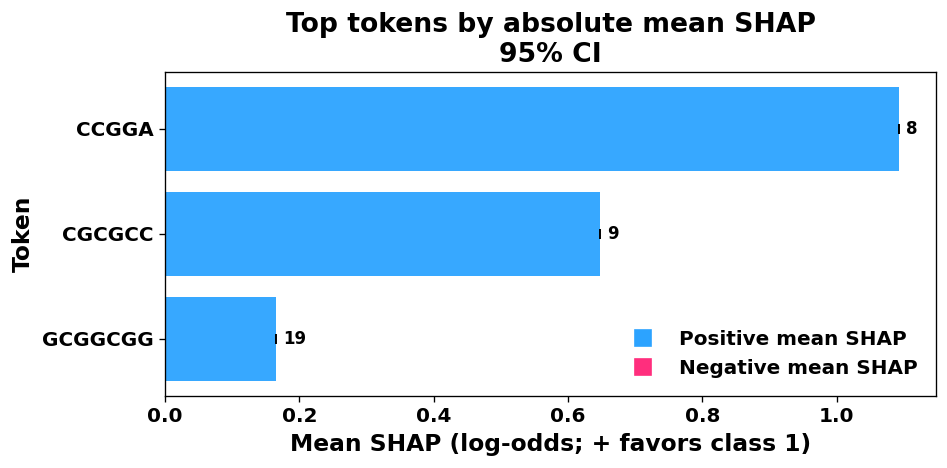

In [24]:
plot_df = top_tokens.sort_values("mean_shap", ascending=True).reset_index(drop=True)
y = np.arange(len(plot_df))

# colors by sign
pos_color = "#2CA3FF"   # blue
neg_color = "#FF2E7D"   # pink
bar_colors = [pos_color if v >= 0 else neg_color for v in plot_df["mean_shap"]]

# figure
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)

# bars with CI
ax.barh(
    y, plot_df["mean_shap"], xerr=plot_df["ci95"],
    alpha=0.95, color=bar_colors, zorder=1, capsize=3
)

# 0 reference line
ax.axvline(0, linewidth=1, color="k", alpha=0.6, zorder=2)

# annotate frequencies
for i, (m, f) in enumerate(zip(plot_df["mean_shap"], plot_df["freq"])):
    ax.text(
        m + 0.01 * (1 if m >= 0 else -1), i, f"{f}",
        va="center", ha="left" if m >= 0 else "right",
        fontsize=10, fontweight="bold"
    )

# y labels
ax.set_yticks(y)
ax.set_yticklabels(list(plot_df["token"]), fontweight="bold", fontsize=12)

# labels and title
ax.set_xlabel("Mean SHAP (log-odds; + favors class 1)", fontsize=14, fontweight="bold")
ax.set_ylabel("Token", fontsize=14, fontweight="bold")
ax.set_title(
    f"Top tokens by {'frequency' if rank_by=='freq' else 'absolute mean SHAP'}\n95% CI",
    fontsize=16, fontweight="bold"
)

# tick fonts
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight("bold")

# legend
pos_patch = mlines.Line2D([], [], color=pos_color, marker='s', linestyle='None',
                          markersize=10, label='Positive mean SHAP')
neg_patch = mlines.Line2D([], [], color=neg_color, marker='s', linestyle='None',
                          markersize=10, label='Negative mean SHAP')
ax.legend(handles=[pos_patch, neg_patch], loc='lower right', frameon=False,
          prop={"size": 12, "weight": "bold"})

plt.tight_layout()

# ── Save directly as PDF (high resolution, bold text preserved)
pdf_path = os.path.join(job["res_pdir"], "TopTokens_SHAP_barh.pdf")
fig.savefig(pdf_path, format="pdf", dpi=600, bbox_inches="tight")

plt.show()

In [ ]:
# # example try
# df_res['merged_token'][0]

# seqs = load_sequences(
#     input_csv=job["res_pdir"] + '/4sig_motifs_prePWM.csv',
#     sequence_col="Sequence", top_n=None)
# len(seqs)

# # predict_fn, mask_token = build_predict_fn_idsafe(tokenizer, model, device, target_class=1)

# seq = seqs[1]
# tok = tokenizer.tokenize(seq)[:10]; print(len(tok))
# bg = np.array([[mask_token]*len(tok)], dtype=object)

# # run shap
# ex, df_tokens = explain_sequence(seq, tokenizer, predict_fn, mask_token, max_len=10, nsamples=10)

# df_tokens.head()

# shap.plots.waterfall(ex, max_display=5)  
